# LightAutoML Pipeline для Optiver Trading at the Close

Этот ноутбук реализует пайплайн LightAutoML для прогнозирования движения цен акций во время закрывающих аукционов NASDAQ.

**Соревнование:** Optiver - Trading at the Close  
**Задача:** Регрессия (прогнозирование движения цен)  
**Метрика:** MAE (Mean Absolute Error)

## 1. Настройка и импорт библиотек

In [61]:
import os
import copy
# Optional: set the device to run
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

In [62]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
# LightAutoML presets, task and report generation
from lightautoml_gpu.automl.presets.gpu.tabular_gpu_presets import TabularAutoMLGPU
from lightautoml_gpu.tasks import Task
from lightautoml_gpu.report.gpu import ReportDeco
from sklearn.metrics import mean_absolute_error

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Пути к данным - используем абсолютный путь от корня проекта
PROJECT_ROOT = Path('/root/Optiver')
DATA_DIR = PROJECT_ROOT / 'data'
TRAIN_PATH = DATA_DIR / 'train.csv'
TEST_PATH = DATA_DIR / 'example_test_files' / 'test.csv'
SUBMISSION_PATH = DATA_DIR / 'submission_lightautoml.csv'

# Проверка существования путей
print(f'Рабочая директория: {os.getcwd()}')
print(f'Тестовый файл существует: {TEST_PATH.exists()}')
print(f'Путь к тестовому файлу: {TEST_PATH}')
print('Настройка завершена!')

Рабочая директория: /root/Optiver/notebooks
Тестовый файл существует: True
Путь к тестовому файлу: /root/Optiver/data/example_test_files/test.csv
Настройка завершена!


## 2. Загрузка данных

In [63]:
# Определение оптимизированных типов данных для экономии памяти
dtypes = {
    'stock_id': 'int16',
    'date_id': 'int16',
    'seconds_in_bucket': 'int16',
    'imbalance_size': 'float32',
    'imbalance_buy_sell_flag': 'int8',
    'reference_price': 'float32',
    'matched_size': 'float32',
    'far_price': 'float32',
    'near_price': 'float32',
    'bid_price': 'float32',
    'bid_size': 'float32',
    'ask_price': 'float32',
    'ask_size': 'float32',
    'wap': 'float32',
    'target': 'float32',
    'time_id': 'int32',
    'row_id': 'str'
}

print('Загрузка обучающих данных...')
train_df = pd.read_csv(TRAIN_PATH, dtype=dtypes)
print(f'Размер train: {train_df.shape}')
print(f'Использование памяти: {train_df.memory_usage(deep=True).sum() / 1e6:.2f} МБ')

Загрузка обучающих данных...
Размер train: (5237980, 17)
Использование памяти: 639.15 МБ


In [64]:
# Загрузка тестовых данных
test_dtypes = {k: v for k, v in dtypes.items() if k != 'target'}
print('Загрузка тестовых данных...')
test_df = pd.read_csv(TEST_PATH, dtype=test_dtypes)
print(f'Размер test: {test_df.shape}')

Загрузка тестовых данных...
Размер test: (33000, 17)


In [65]:
# Быстрый осмотр данных
print('Пример обучающих данных:')
display(train_df.head())
print('\nИнформация о данных:')
print(train_df.info())
print('\nСтатистика целевой переменной:')
print(train_df['target'].describe())

Пример обучающих данных:


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3.180603e+06,1,0.999812,13380277.00,NaN,NaN,0.999812,60651.500000,1.000026,8493.030273,1.0,-3.029704,0,0_0_0
1,1,0,0,1.666039e+05,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.040039,1.000660,20605.089844,1.0,-5.519986,0,0_0_1
2,2,0,0,3.028799e+05,-1,0.999561,1819368.00,NaN,NaN,0.999403,37956.000000,1.000298,18995.000000,1.0,-8.389950,0,0_0_2
3,3,0,0,1.191768e+07,-1,1.000171,18389746.00,NaN,NaN,0.999999,2324.899902,1.000214,479032.406250,1.0,-4.010201,0,0_0_3
4,4,0,0,4.475500e+05,-1,0.999532,17860614.00,NaN,NaN,0.999394,16485.539062,1.000016,434.100006,1.0,-7.349849,0,0_0_4



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int16  
 1   date_id                  int16  
 2   seconds_in_bucket        int16  
 3   imbalance_size           float32
 4   imbalance_buy_sell_flag  int8   
 5   reference_price          float32
 6   matched_size             float32
 7   far_price                float32
 8   near_price               float32
 9   bid_price                float32
 10  bid_size                 float32
 11  ask_price                float32
 12  ask_size                 float32
 13  wap                      float32
 14  target                   float32
 15  time_id                  int32  
 16  row_id                   object 
dtypes: float32(11), int16(3), int32(1), int8(1), object(1)
memory usage: 314.7+ MB
None

Статистика целевой переменной:
count    5.237892e+06


In [66]:
# Проверка пропущенных значений
missing = train_df.isnull().sum()
missing_pct = (missing / len(train_df) * 100).round(2)
print('Пропущенные значения:')
print(pd.DataFrame({'количество': missing, 'процент': missing_pct})[missing > 0])

# Удаление строк с пропущенной целевой переменной (обязательно для обучения)
print(f'\nСтрок до удаления пропущенных target: {len(train_df):,}')
train_df = train_df.dropna(subset=['target'])
print(f'Строк после удаления пропущенных target: {len(train_df):,}')

Пропущенные значения:
                 количество  процент
imbalance_size          220     0.00
reference_price         220     0.00
matched_size            220     0.00
far_price           2894342    55.26
near_price          2857180    54.55
bid_price               220     0.00
ask_price               220     0.00
wap                     220     0.00
target                   88     0.00

Строк до удаления пропущенных target: 5,237,980
Строк после удаления пропущенных target: 5,237,892


## 3. Создание признаков (Feature Engineering)

На основе результатов EDA мы создаём следующие признаки:
- `book_imbalance`: bid_size - ask_size (признак с наивысшей корреляцией с целевой переменной)
- `wap_ref_diff`: wap - reference_price
- `spread`: ask_price - bid_price (спред)
- `imbalance_ratio`: imbalance_size / matched_size (коэффициент дисбаланса)
- `mid_price`: (bid_price + ask_price) / 2 (средняя цена)

In [67]:
def add_features(df):
    """Добавление инженерных признаков в датафрейм."""
    df = df.copy()
    
    # Дисбаланс книги заявок - признак с наивысшей корреляцией из EDA
    df['book_imbalance'] = df['bid_size'] - df['ask_size']
    
    # Разница между WAP и справочной ценой
    df['wap_ref_diff'] = df['wap'] - df['reference_price']
    
    # Спред между ценой продажи и покупки
    df['spread'] = df['ask_price'] - df['bid_price']
    
    # Коэффициент дисбаланса (обработка деления на ноль)
    df['imbalance_ratio'] = df['imbalance_size'] / (df['matched_size'] + 1e-8)
    
    # Средняя цена
    df['mid_price'] = (df['bid_price'] + df['ask_price']) / 2
    df.dropna(inplace=True)
    return df

print('Добавление признаков к обучающим данным...')
train_df = add_features(train_df)
print(f'Новые столбцы: {[c for c in train_df.columns if c not in dtypes.keys()]}')

print('\nДобавление признаков к тестовым данным...')
test_df = add_features(test_df)

Добавление признаков к обучающим данным...
Новые столбцы: ['book_imbalance', 'wap_ref_diff', 'spread', 'imbalance_ratio', 'mid_price']

Добавление признаков к тестовым данным...


In [68]:
# Проверка новых признаков
new_features = ['book_imbalance', 'wap_ref_diff', 'spread', 'imbalance_ratio', 'mid_price']
print('Статистика новых признаков:')
display(train_df[new_features].describe())

Статистика новых признаков:


,book_imbalance,wap_ref_diff,spread,imbalance_ratio,mid_price
count,2.343638e+06,2.343638e+06,2.343638e+06,2.343638e+06,2.343638e+06
mean,-2.808211e+03,-4.632795e-06,4.631183e-04,6.231711e-02,9.999793e-01
std,1.698308e+05,3.288030e-04,5.173644e-04,9.165100e-02,3.027388e-03
min,-5.168268e+07,-8.765996e-03,2.980232e-06,0.000000e+00,9.373710e-01
25%,-3.106213e+04,-1.109838e-04,1.859665e-04,0.000000e+00,9.982920e-01
50%,-7.059009e+02,0.000000e+00,3.129244e-04,2.941079e-02,9.999255e-01
75%,2.730495e+04,1.040697e-04,5.660057e-04,8.915670e-02,1.001590e+00
max,2.864833e+07,1.171595e-02,1.337194e-02,5.111570e+00,1.077662e+00


## 4. Разделение на обучающую и валидационную выборки

Мы используем разбиение по времени для сохранения временного порядка и предотвращения утечки данных (data leakage).

In [69]:
# Разбиение по времени: используем последние 20% дат для валидации
n_dates = train_df['date_id'].nunique()
val_dates = int(n_dates * 0.2)
split_date = train_df['date_id'].max() - val_dates

print(f'Всего уникальных дат: {n_dates}')
print(f'Дата разделения (date_id): {split_date}')
print(f'Даты для обучения: 0 до {split_date}')
print(f'Даты для валидации: {split_date + 1} до {train_df["date_id"].max()}')

# Создание масок для train/validation
train_mask = train_df['date_id'] <= split_date
val_mask = train_df['date_id'] > split_date

train_data = train_df[train_mask].copy()
val_data = train_df[val_mask].copy()

print(f'\nРазмер обучающей выборки: {len(train_data):,} ({len(train_data)/len(train_df)*100:.1f}%)')
print(f'Размер валидационной выборки: {len(val_data):,} ({len(val_data)/len(train_df)*100:.1f}%)')

Всего уникальных дат: 481
Дата разделения (date_id): 384
Даты для обучения: 0 до 384
Даты для валидации: 385 до 480

Размер обучающей выборки: 1,870,021 (79.8%)
Размер валидационной выборки: 473,617 (20.2%)


In [70]:
# Создание маленького train set для отладки (первые 20% дат)
unique_dates = sorted(train_df['date_id'].unique())
small_train_dates = int(len(unique_dates) * 0.2)
small_split_date = unique_dates[small_train_dates - 1]

train_small_mask = train_df['date_id'] <= small_split_date

train_data = train_df[train_small_mask].copy()
train_data.reset_index(drop=True, inplace=True)


print(f'\n[DEBUG] Маленький train set (первые 20% дат):')
print(f'[DEBUG] Даты: {unique_dates[0]} до {small_split_date}')
print(f'[DEBUG] Размер train_small_data: {len(train_data):,} ({len(train_data)/len(train_df)*100:.1f}%)')



[DEBUG] Маленький train set (первые 20% дат):
[DEBUG] Даты: 0 до 95
[DEBUG] Размер train_small_data: 457,407 (19.5%)


## 5. Сравнение конфигураций AutoML

Мы сравниваем две различные конфигурации LightAutoML для поиска лучшего подхода:
1. **Полный ансамбль (CB+XGB)**: Объединяет CatBoost (GPU) и XGBoost (GPU)
2. **Двухуровневый стекинг**: Уровень 1: CatBoost (GPU), Уровень 2: LightGBM (CPU)


In [72]:
# Определение столбцов для исключения (идентификаторы, не признаки)
drop_cols = ['row_id', 'time_id']

# Определение задачи
task = Task('reg', metric='mae')

# Конфигурация 1: Полный ансамбль (CB+XGB) - Лучше для точности
# Объединяет сильные стороны лучших библиотек градиентного бустинга
config_full_ensemble = TabularAutoMLGPU(
    task=task,
    timeout=180,  # 3 минуты
    cpu_limit=96,
    gpu_ids='0',  # Указываем GPU
    general_params={
        'use_algos': [['cb',
                        'xgb'
                        ]],
    },
    reader_params={
        'random_state': RANDOM_STATE,
        'cv': 5,
        'advanced_roles': False, 
    },
    # CatBoost GPU параметры
    cb_params={
        'default_params': {
            'task_type': 'GPU',
            'devices': '0',
            'gpu_ram_part': 0.9,
        }
    }
)

# Конфигурация 2: Двухуровневый стекинг CB -> LGB
config_stacking = TabularAutoMLGPU(
    task=task,
    timeout=360,  # 3 минуты
    cpu_limit=96,
    general_params={
        'use_algos': [['cb'], ['xgb']],  # Уровень 1: CB (GPU), Уровень 2: XGB
    },
    reader_params={
        'random_state': RANDOM_STATE,
        'cv': 2,
        'advanced_roles': False, 
    },
    cb_params={
        'default_params': {
            'task_type': 'GPU',
            'devices': '0',
        }
    }
)

# Сохранение конфигураций в список
automl_configs = [("Полный ансамбль", config_full_ensemble), 
                  ("Двухуровневый стекинг", config_stacking)]

In [73]:
def export_lama_preset(model):
    # берём только сериализуемые/полезные куски, без огромных объектов после fit
    out = {
        "class": model.__class__.__name__,
        "config_path": getattr(model, "config_path", None),
        "timeout": getattr(getattr(model, "timer", None), "timeout", None),
        "cpu_limit": getattr(model, "cpu_limit", None),
        "gpu_ids": getattr(model, "gpu_ids", None),
        "memory_limit": getattr(model, "memory_limit", None),
        "task": getattr(getattr(model, "task", None), "name", None),
    }
    # типовые секции пресета (если есть)
    for k in [
        "general_params", "reader_params", "read_csv_params", "nested_cv_params",
        "tuning_params", "selection_params",
        "cb_params", "xgb_params", "lgb_params", "rf_params", "linear_l2_params", "nn_params",
        "gbm_pipeline_params", "linear_pipeline_params", "nn_pipeline_params", "time_series_pipeline_params",
        "timing_params",
    ]:
        if hasattr(model, k):
            out[k] = copy.deepcopy(getattr(model, k))
    return out

In [74]:
def train_and_evaluate_config(config, train_data, val_data, drop_cols):
    """
    Обучение модели AutoML с заданной конфигурацией и её оценка.
    
    Следует best practices из документации LightAutoML:
    1. fit_predict() - обучение + OOF предсказания (cross-validated)
    2. predict() - предсказания на отложенной выборке
    
    Аргументы:
        config: Tuple (name, TabularAutoML instance)
        train_data: DataFrame для обучения
        val_data: DataFrame для валидации
        drop_cols: Столбцы для исключения при обучении
        
    Возвращает:
        Словарь с результатами, включая модель, OOF MAE и валидационный MAE
    """
    import time
    
    name, model = config
    
    print(f"\n{'='*60}")
    print(f"Обучение: {name}")
    print(f"{'='*60}")
    
    # Определение ролей признаков
    roles = {
        'target': 'target',
        'drop': drop_cols
    }
    
    # ==================== ШАГ 1: FIT ====================
    # fit_predict() обучает модель и возвращает OOF предсказания
    # OOF (out-of-fold) - несмещённые предсказания через кросс-валидацию
    print("\n[1/2] Обучение модели (fit_predict)...")
    start_time = time.time()
    
    oof_predictions = model.fit_predict(
        train_data,
        roles=roles,
        verbose=4,
        # log_file="logs/lightautoml_training.log",
        # path_to_save="models/lightautoml_model.pkl"
    )
    
    fit_time = time.time() - start_time
    print(f"Время обучения: {fit_time:.1f} сек")
    
    # Извлечение OOF предсказаний
    oof_preds = oof_predictions.data[:, 0]
    
    # Ignore rows with NaN in target or predictions for MAE calculation 
    mask = ~np.isnan(train_data['target']) & ~np.isnan(oof_preds)
    oof_mae = mean_absolute_error(train_data['target'][mask], oof_preds[mask])
    # oof_mae = mean_absolute_error(train_data['target'], oof_preds)
    print(f"OOF MAE: {oof_mae:.6f}")
    
    # ==================== ШАГ 2: PREDICT ====================
    # predict() применяет обученную модель к новым данным
    print("\n[2/2] Предсказание на валидации (predict)...")
    predict_start = time.time()
    
    # ВАЖНО: Сбрасываем индекс val_data перед predict для корректной работы
    val_data_reset = val_data.reset_index(drop=True)
    val_predictions = model.predict(val_data_reset)
    
    predict_time = time.time() - predict_start
    print(f"Время предсказания: {predict_time:.1f} сек")
    
    # ДИАГНОСТИКА: Проверка формы предсказаний
    print(f"\n[DEBUG] val_predictions.data.shape: {val_predictions.data.shape}")
    print(f"[DEBUG] Ожидаемое количество строк: {len(val_data)}")
    
    # Извлечение валидационных предсказаний
    val_preds = val_predictions.data[:, 0]
    val_mae = mean_absolute_error(val_data['target'], val_preds)
    print(f"Валидационный MAE: {val_mae:.6f}")
    
    # ==================== ИТОГИ ====================
    total_time = fit_time + predict_time
    
    print(f"\n{'─'*40}")
    print(f"Результаты для {name}:")
    print(f"  OOF MAE:          {oof_mae:.6f}")
    print(f"  Валидационный MAE: {val_mae:.6f}")
    print(f"  Общее время:       {total_time:.1f} сек ({total_time/60:.1f} мин)")
    print(f"{'─'*40}")
    
    # Проверка GPU использования (для CatBoost)
    for level in model.levels:
        for pipe in level:
            for ml_algo in pipe.ml_algos:
                if hasattr(ml_algo, 'models') and ml_algo.models:
                    for i, m in enumerate(ml_algo.models):
                        if hasattr(m, 'get_param'):
                            task_type = m.get_param('task_type')
                            print(f"  {ml_algo.__class__.__name__} fold {i}: task_type={task_type}")
    
    return {
        'name': name,
        "config": export_lama_preset(model),
        'model': model,
        'oof_mae': oof_mae,
        'val_mae': val_mae,
        'training_time': total_time,
        'fit_time': fit_time,
        'predict_time': predict_time,
        'oof_preds': oof_preds,
        'val_preds': val_preds,
    }

In [75]:
def plot_comparison_results(results):
    """
    Создание графиков сравнения различных конфигураций AutoML.
    
    Аргументы:
        results: Список словарей с результатами от train_and_evaluate_config
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    names = [r['name'] for r in results]
    oof_maes = [r['oof_mae'] for r in results]
    val_maes = [r['val_mae'] for r in results]
    times = [r['training_time'] / 60 for r in results]  # Перевод в минуты
    
    x = np.arange(len(names))
    width = 0.35
    
    # График 1: Сравнение MAE
    ax1 = axes[0]
    bars1 = ax1.bar(x - width/2, oof_maes, width, label='OOF MAE', color='steelblue')
    bars2 = ax1.bar(x + width/2, val_maes, width, label='Val MAE', color='coral')
    ax1.set_xlabel('Конфигурация')
    ax1.set_ylabel('MAE')
    ax1.set_title('Сравнение MAE')
    ax1.set_xticks(x)
    ax1.set_xticklabels(names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # График 2: Время обучения
    ax2 = axes[1]
    bars3 = ax2.bar(names, times, color='forestgreen')
    ax2.set_xlabel('Конфигурация')
    ax2.set_ylabel('Время обучения (минуты)')
    ax2.set_title('Сравнение времени обучения')
    ax2.set_xticklabels(names, rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    
    # График 3: Эффективность (MAE на минуту)
    ax3 = axes[2]
    efficiency = [val_mae / time for val_mae, time in zip(val_maes, times)]
    bars4 = ax3.bar(names, efficiency, color='purple')
    ax3.set_xlabel('Конфигурация')
    ax3.set_ylabel('Val MAE / Время (меньше — лучше)')
    ax3.set_title('Показатель эффективности')
    ax3.set_xticklabels(names, rotation=45, ha='right')
    ax3.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
        
    # Сортировка по валидационному MAE
    sorted_results = sorted(results, key=lambda x: x['val_mae'])
    for r in sorted_results:
        print(f"{r['name']:<30} {r['oof_mae']:>12.6f} {r['val_mae']:>12.6f} {r['training_time']/60:>12.1f}")
    
    print('='*80)
    best = sorted_results[0]
    print(f"\nЛучшая конфигурация: {best['name']} (Val MAE: {best['val_mae']:.6f})")
    
    return sorted_results[0]  # Возврат лучшего результата

In [76]:
results = []

In [77]:
result_conf1 = train_and_evaluate_config(automl_configs[0], train_data, val_data, drop_cols)
results.append(result_conf1)


Обучение: Полный ансамбль

[1/2] Обучение модели (fit_predict)...
[12:40:57] Stdout logging level is DEBUG.
[12:40:57] Task: reg

[12:40:57] Start automl preset with listed constraints:
[12:40:57] - time: 180.00 seconds
[12:40:57] - CPU: 96 cores
[12:40:57] - memory: 16 GB

[12:40:57] Train data shape: (457407, 22)
[12:40:58] Layer 1 train process start. Time left 179.85 secs


Default metric period is 5 because MAE is/are not implemented for GPU


[12:41:02] Time history [4.571820020675659]. Time left 22.34510374069214
[12:41:02] Selector_CatBoostGPU fitting and predicting completed
[12:41:03] Start fitting Lvl_0_Pipe_0_Mod_0_CatBoostGPU ...
[12:41:03] Training params: {'task_type': 'GPU', 'devices': '0', 'thread_count': 96, 'random_seed': 42, 'num_trees': 2000, 'learning_rate': 0.05, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 300, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': False, 'max_ctr_complexity': 1, 'gpu_ram_part': 0.9}
[12:41:03] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_CatBoostGPU (orig) =====


Default metric period is 5 because MAE is/are not implemented for GPU


[12:41:07] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_CatBoostGPU (orig) =====


Default metric period is 5 because MAE is/are not implemented for GPU


[12:41:12] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_CatBoostGPU (orig) =====


Default metric period is 5 because MAE is/are not implemented for GPU


[12:41:17] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_CatBoostGPU (orig) =====


Default metric period is 5 because MAE is/are not implemented for GPU


[12:41:22] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_CatBoostGPU (orig) =====


Default metric period is 5 because MAE is/are not implemented for GPU


[12:41:27] Time history [4.571820020675659, 4.612808704376221, 4.923666715621948, 4.850359201431274, 4.935390949249268, 4.942953824996948]. Time left 6.557015371322635
[12:41:27] Fitting Lvl_0_Pipe_0_Mod_0_CatBoostGPU finished. score = -4.997526168823242
[12:41:27] Lvl_0_Pipe_0_Mod_0_CatBoostGPU fitting and predicting completed
[12:41:27] Start fitting Lvl_0_Pipe_0_Mod_1_XGB ...
[12:41:27] Training params: {'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'task': 'train', 'learning_rate': 0.05, 'max_leaves': 128, 'max_depth': 0, 'verbosity': 0, 'reg_alpha': 1, 'reg_lambda': 0.0, 'gamma': 0.0, 'max_bin': 255, 'n_estimators': 2000, 'early_stopping_rounds': 100, 'random_state': 42, 'nthread': 96}
[12:41:28] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_XGB (orig) =====
[12:41:40] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_1_XGB (orig) =====
[12:41:52] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_1_XGB (orig) =====
[12:42:04] ===== Start working with fold

In [78]:
result_conf2 = train_and_evaluate_config(automl_configs[1], train_data, val_data, drop_cols)
results.append(result_conf2)


Обучение: Двухуровневый стекинг

[1/2] Обучение модели (fit_predict)...
[12:42:28] Stdout logging level is DEBUG.
[12:42:28] Task: reg

[12:42:28] Start automl preset with listed constraints:
[12:42:28] - time: 360.00 seconds
[12:42:28] - CPU: 96 cores
[12:42:28] - memory: 16 GB

[12:42:28] Train data shape: (457407, 22)
[12:42:28] Layer 1 train process start. Time left 359.79 secs


Default metric period is 5 because MAE is/are not implemented for GPU


[12:42:33] Time history [4.16583251953125]. Time left 58.05846641613886
[12:42:33] Selector_CatBoostGPU fitting and predicting completed
[12:42:33] Start fitting Lvl_0_Pipe_0_Mod_0_CatBoostGPU ...
[12:42:33] Training params: {'task_type': 'GPU', 'devices': '0', 'thread_count': 96, 'random_seed': 42, 'num_trees': 2000, 'learning_rate': 0.05, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 300, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': False, 'max_ctr_complexity': 1}
[12:42:33] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_CatBoostGPU (orig) =====


Default metric period is 5 because MAE is/are not implemented for GPU


[12:42:37] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_CatBoostGPU (orig) =====


Default metric period is 5 because MAE is/are not implemented for GPU


[12:42:41] Time history [4.16583251953125, 4.114407539367676, 4.232771396636963]. Time left 67.44427274522327
[12:42:41] Fitting Lvl_0_Pipe_0_Mod_0_CatBoostGPU finished. score = -5.01175594329834
[12:42:41] Lvl_0_Pipe_0_Mod_0_CatBoostGPU fitting and predicting completed
[12:42:41] Time left 346.65 secs

[12:42:41] Layer 1 training completed.

[12:42:41] Layer 2 train process start. Time left 346.62 secs
[12:42:42] Start fitting Lvl_1_Pipe_0_Mod_0_XGB ...
[12:42:42] Training params: {'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'task': 'train', 'learning_rate': 0.05, 'max_leaves': 128, 'max_depth': 0, 'verbosity': 0, 'reg_alpha': 1, 'reg_lambda': 0.0, 'gamma': 0.0, 'max_bin': 255, 'n_estimators': 2000, 'early_stopping_rounds': 100, 'random_state': 42, 'nthread': 96}
[12:42:42] ===== Start working with fold 0 for Lvl_1_Pipe_0_Mod_0_XGB (orig) =====
[12:42:53] ===== Start working with fold 1 for Lvl_1_Pipe_0_Mod_0_XGB (orig) =====
[12:43:05] Time history [11.543027400970459, 1

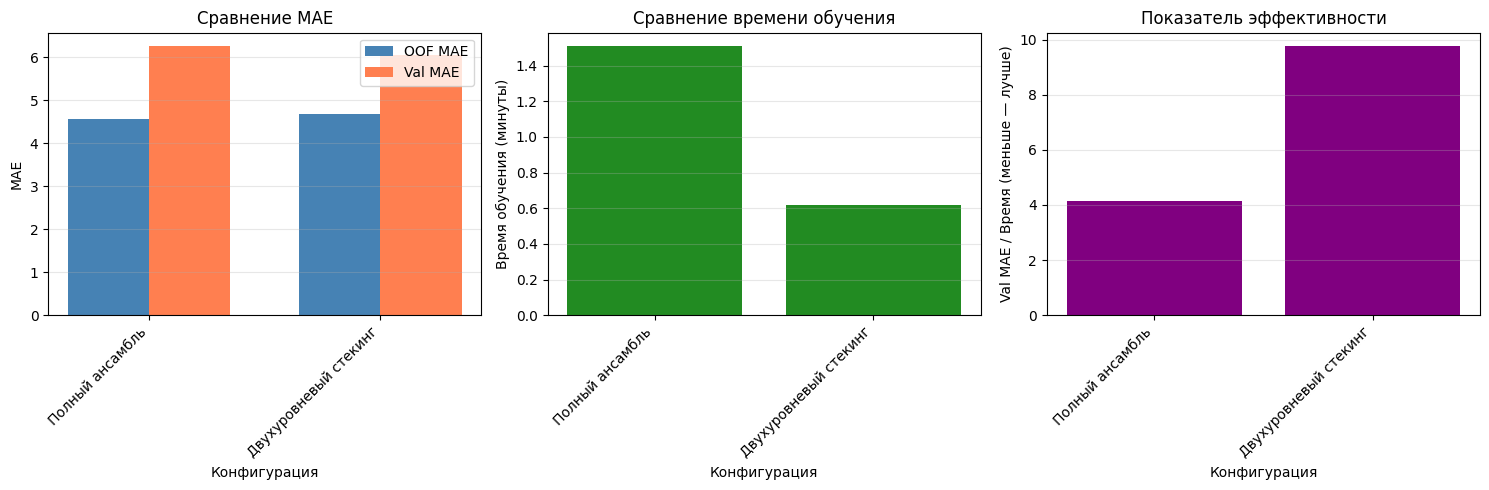

Двухуровневый стекинг              4.676551     6.041665          0.6
Полный ансамбль                    4.564025     6.256442          1.5

Лучшая конфигурация: Двухуровневый стекинг (Val MAE: 6.041665)


In [79]:
# Визуализация сравнения и выбор лучшей конфигурации
best_result = plot_comparison_results(results)

## 6. Выбор лучшей конфигурации

In [80]:
# Выбор лучшей конфигурации на основе валидационного MAE
best_config = best_result['config']
best_model = best_result['model']

print(f"Название: {best_result['name']}")
print(f"Валидационный MAE: {best_result['val_mae']:.6f}")
print(f"OOF MAE: {best_result['oof_mae']:.6f}")
print(f"Время обучения: {best_result['training_time']/60:.1f} минут")
print(f"Алгоритмы: {best_config['general_params']['use_algos']}")
print('='*60)

Название: Двухуровневый стекинг
Валидационный MAE: 6.041665
OOF MAE: 4.676551
Время обучения: 0.6 минут
Алгоритмы: [['cb'], ['xgb']]


## 7. Обучение лучшей конфигурации на полных данных

Переобучаем лучшую конфигурацию на полном обучающем наборе данных для финальной отправки.

In [84]:
best_config

{'class': 'TabularAutoMLGPU',
 'config_path': None,
 'timeout': 360,
 'cpu_limit': 96,
 'gpu_ids': '0',
 'memory_limit': 16,
 'task': 'reg',
 'general_params': {'use_algos': [['cb'], ['xgb']],
  'nested_cv': False,
  'skip_conn': True,
  'return_all_predictions': False,
  'weighted_blender_max_nonzero_coef': 0.05,
  'parallel_folds': False},
 'reader_params': {'samples': 100000,
  'max_nan_rate': 0.999,
  'max_constant_rate': 0.999,
  'cv': 2,
  'random_state': 42,
  'roles_params': None,
  'n_jobs': 1,
  'advanced_roles': False,
  'numeric_unique_rate': 0.999,
  'max_to_3rd_rate': 1.1,
  'binning_enc_rate': 2,
  'raw_decr_rate': 1.1,
  'max_score_rate': 0.2,
  'abs_score_val': 0.04,
  'drop_score_co': 0.0,
  'index_ok': True,
  'npartitions': 4},
 'read_csv_params': {'decimal': '.', 'sep': ','},
 'nested_cv_params': {'cv': 1,
  'n_folds': None,
  'inner_tune': False,
  'refit_tuner': False},
 'tuning_params': {'fit_on_holdout': True,
  'max_tuning_iter': 101,
  'max_tuning_time': 300}

In [106]:
import re

path = "/root/Optiver/.venv/lib/python3.11/site-packages/lightautoml_gpu/ml_algo/gpu/base_gpu.py"

with open(path, "r", encoding="utf-8") as f:
    lines = f.readlines()

# если уже патчено — не трогаем
if any("except TypeError" in l and "iterator_len" in l for l in lines):
    print("ℹ️ Похоже, файл уже содержит патч (except TypeError). Пропускаю.")
else:
    target = "iterator_len = len(train_valid_iterator)"
    idx = next((i for i, l in enumerate(lines) if target in l), None)
    if idx is None:
        raise RuntimeError("Не нашёл строку `iterator_len = len(train_valid_iterator)` в base_gpu.py")

    indent = re.match(r"\s*", lines[idx]).group(0)

    block = [
        indent + "try:\n",
        indent + "    iterator_len = len(train_valid_iterator)\n",
        indent + "except TypeError:\n",
        indent + "    import numpy as _np\n",
        indent + "    _v = train_valid_iterator.__len__()\n",
        indent + "    iterator_len = int(_np.asarray(_v).ravel()[0])\n",
    ]

    lines[idx:idx+1] = block

    with open(path, "w", encoding="utf-8") as f:
        f.writelines(lines)

    print("✅ Patched base_gpu.py with correct indentation")


✅ Patched base_gpu.py with correct indentation


In [107]:
import sys, importlib

# вычищаем всё lightautoml_gpu из sys.modules (чтобы не было полузагруженных модулей)
for m in [m for m in list(sys.modules) if m.startswith("lightautoml_gpu")]:
    del sys.modules[m]

importlib.invalidate_caches()

# теперь импорт должен пройти
from lightautoml_gpu.automl.presets.gpu.tabular_gpu_presets import TabularAutoMLGPU
from lightautoml_gpu.tasks import Task

print("✅ Imports OK")


Level "INFO2: 17" already defined, skipping...
Level "INFO3: 13" already defined, skipping...
✅ Imports OK


In [114]:


task = Task("reg", metric="mae")
roles = {"target": "target", "drop": drop_cols}

train_full = train_df.dropna(subset=["target"]).reset_index(drop=True)

cfg = copy.deepcopy(best_config)


cfg["reader_params"]["cv"] = 2 

# стабилизаторы больших данных / cupy
cfg["reader_params"]["npartitions"] = 1
cfg["reader_params"]["index_ok"] = False
cfg["reader_params"]["n_jobs"] = 1


automl_final = TabularAutoMLGPU(
    task=task,
    timeout=cfg["timeout"],
    cpu_limit=cfg["cpu_limit"],
    gpu_ids=cfg["gpu_ids"],
    general_params=cfg["general_params"], 
    reader_params=cfg["reader_params"],
    cb_params=cfg.get("cb_params"),
    xgb_params=cfg.get("xgb_params"),
)

oof_predictions = automl_final.fit_predict(train_full, roles=roles, verbose=3, log_file="fit_full.log")
print("DONE")


[14:03:20] Stdout logging level is INFO3.
[14:03:20] Task: reg

[14:03:20] Start automl preset with listed constraints:
[14:03:20] - time: 360.00 seconds
[14:03:20] - CPU: 96 cores
[14:03:20] - memory: 16 GB

[14:03:20] Train data shape: (2343638, 22)
[14:03:20] Layer 1 train process start. Time left 359.69 secs


Default metric period is 5 because MAE is/are not implemented for GPU


[14:03:29] Selector_CatBoostGPU fitting and predicting completed
[14:03:30] Start fitting Lvl_0_Pipe_0_Mod_0_CatBoostGPU ...
[14:03:30] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_CatBoostGPU (orig) =====


Default metric period is 5 because MAE is/are not implemented for GPU


[14:03:39] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_CatBoostGPU (orig) =====


Default metric period is 5 because MAE is/are not implemented for GPU


[14:03:48] Fitting Lvl_0_Pipe_0_Mod_0_CatBoostGPU finished. score = -5.562588214874268
[14:03:48] Lvl_0_Pipe_0_Mod_0_CatBoostGPU fitting and predicting completed
[14:03:48] Time left 332.33 secs

[14:03:48] Layer 1 training completed.

[14:03:48] Layer 2 train process start. Time left 332.30 secs
[14:03:48] Start fitting Lvl_1_Pipe_0_Mod_0_XGB ...
[14:03:48] ===== Start working with fold 0 for Lvl_1_Pipe_0_Mod_0_XGB (orig) =====
[14:04:06] ===== Start working with fold 1 for Lvl_1_Pipe_0_Mod_0_XGB (orig) =====
[14:04:23] Fitting Lvl_1_Pipe_0_Mod_0_XGB finished. score = -5.4000163078308105
[14:04:23] Lvl_1_Pipe_0_Mod_0_XGB fitting and predicting completed
[14:04:23] Time left 296.63 secs

[14:04:23] Layer 2 training completed.

[14:04:23] Automl preset training completed in 63.38 seconds

[14:04:23] Model description:
Models on level 0:
	 2 averaged models Lvl_0_Pipe_0_Mod_0_CatBoostGPU

Final prediction for new objects (level 1) = 
	 1.00000 * (2 averaged models Lvl_1_Pipe_0_Mod_0_XGB)

In [115]:
# Расчёт OOF MAE на полных обучающих данных
oof_preds = oof_predictions.data[:, 0]
oof_mae = mean_absolute_error(train_df['target'], oof_preds)
print(f'\nOOF MAE на полных данных: {oof_mae:.6f}')
print('Обучение на полных данных завершено!')


OOF MAE на полных данных: 5.400016
Обучение на полных данных завершено!


## 8. Оценка и результаты

Генерация предсказаний на тестовых данных, создание файла для отправки и сохранение финальной модели.

In [119]:
# Генерация предсказаний на тестовых данных
test_used = test_df.reset_index(drop=True)
test_preds = automl_final.predict(test_used).data[:, 0]


print(f'Размер тестовых предсказаний: {test_preds.shape}')
print(f'Диапазон тестовых предсказаний: [{test_preds.min():.4f}, {test_preds.max():.4f}]')
print(f'Среднее тестовых предсказаний: {test_preds.mean():.4f}')
print(f'Стд. откл. тестовых предсказаний: {test_preds.std():.4f}')

Размер тестовых предсказаний: (14771,)
Диапазон тестовых предсказаний: [-79.5367, 60.3154]
Среднее тестовых предсказаний: -0.0925
Стд. откл. тестовых предсказаний: 2.6718


In [120]:


test_predictions = automl_final.predict(test_used)
test_preds = test_predictions.data[:, 0]

print("len(test_used):", len(test_used))
print("len(test_preds):", len(test_preds))

assert len(test_used) == len(test_preds), "predict вернул не то число строк — проверь, что test_used не менялся!"

submission = pd.DataFrame({
    "row_id": test_used["row_id"].values,
    "target": test_preds,
})

print(submission.head())
print("submission shape:", submission.shape)

submission.to_csv(SUBMISSION_PATH, index=False)
print(f"saved: {SUBMISSION_PATH}")

len(test_used): 14771
len(test_preds): 14771
      row_id    target
0  478_300_0 -0.077384
1  478_300_2 -0.060287
2  478_300_3  0.787542
3  478_300_4  0.771963
4  478_300_5  1.111390
submission shape: (14771, 2)
saved: /root/Optiver/data/submission_lightautoml.csv


In [121]:
# Сохранение обученной модели
import pickle

# Создаем директорию models при необходимости
model_dir = PROJECT_ROOT / 'models'
os.makedirs(model_dir, exist_ok=True)

model_path = model_dir / 'automl_final.pkl'

# Сохранение automl_final с помощью pickle
with open(model_path, 'wb') as f:
    pickle.dump(automl_final, f)

# Проверка сохранения файла
file_size = os.path.getsize(model_path) / (1024 * 1024)  # Перевод в МБ
print(f'Модель сохранена: {model_path}')
print(f'Размер файла модели: {file_size:.2f} МБ')

Модель сохранена: /root/Optiver/models/automl_final.pkl
Размер файла модели: 69.30 МБ
